In [1]:
from aquacrop.classes import *
from aquacrop.core import *
 
# import gym
# from gym import spaces
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from aquacrop.lars import *
# import math

In [2]:
from aquacropgym.utils import calc_eto_faopm
from aquacropgym.envs import CropEnv, nebraska_maize_config, cordoba_cotton_config,california_tomato_config
from aquacropgym.utils import evaluate_agent,evaluate_agent_single_year
from aquacropgym.utils import calc_eto_faopm

In [3]:
#CP  Lat.(deg)= 40.40  Long.(deg)=101.73  Elev.(m)=1072.
gendf=calc_eto_faopm('data/CPWG.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])

In [4]:
gendf.head()

,simyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,1,-2.1,-1.2,0.0,0.840868,1995-01-01
1,1,-11.0,18.9,0.0,3.425219,1995-01-02
2,1,-9.0,8.2,0.0,1.950843,1995-01-03
3,1,-5.8,16.5,0.0,2.889402,1995-01-04
4,1,-8.4,-0.8,0.0,1.078832,1995-01-05


In [5]:
from aquacropgym.envs import CropEnv, nebraska_maize_config

In [6]:
envconfig=nebraska_maize_config.copy()
envconfig['gendf']=gendf
envconfig['action_set']='depth'
# envconfig['observation_set']='forecast'
envconfig['days_to_irr']=1



In [7]:
env=CropEnv(envconfig)
# env.get_mean_std(1000)

In [8]:
env.mean

array([1.5297709e+01, 6.7175574e+00, 4.3340582e-01, 6.7000000e+01,
       1.2093769e+02, 6.6166919e-01, 1.2499705e+03, 2.2275937e+00,
       5.9314189e+00, 1.6487059e+02, 3.8849683e+02, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32)

In [9]:
env.std

array([8.9132442e+00, 1.2556748e+00, 2.2046985e-01, 3.7815342e+01,
       7.7468857e+01, 3.7401891e-01, 1.0447410e+03, 2.7044525e+00,
       9.5832235e-01, 1.0854125e+02, 2.3682135e+02, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00], dtype=float32)

In [10]:
import ray

In [11]:
ray.shutdown()

In [12]:
ray.init(num_cpus=8,num_gpus=0)

{'node_ip_address': '192.168.93.125',
 'raylet_ip_address': '192.168.93.125',
 'redis_address': '192.168.93.125:6379',
 'object_store_address': '/tmp/ray/session_2022-03-14_12-29-10_568030_28128/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-14_12-29-10_568030_28128/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-14_12-29-10_568030_28128',
 'metrics_export_port': 59017,
 'node_id': 'a0c22d38284d947963efc85da55c508a123c307956e3af0aed5cb14e'}

In [10]:
from ray.rllib.agents.ppo import ppo

config = ppo.DEFAULT_CONFIG.copy()

config['num_workers'] = 16
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 150
config['train_batch_size'] = 150*16
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [21]:
from ray.rllib.agents.ars import ars

config = ars.DEFAULT_CONFIG.copy()

config['num_workers'] = 8
config['observation_filter'] = 'NoFilter'
config['num_rollouts'] = 100
config['rollouts_used'] = 100
config['evaluation_config'] = {}
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150
# config['train_batch_size'] = 150*16
config['model']['fcnet_hiddens'] = []
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [ ]:
# from ray.rllib.agents.dqn.apex import ApexTrainer,APEX_DEFAULT_CONFIG

# config=APEX_DEFAULT_CONFIG.copy()
# config['gamma'] = 0.99999
# config['framework'] = 'torch'
# config['num_workers'] = 8
# config['num_gpus'] = 0
# config['hiddens'] = [256]*2
# config['buffer_size'] = 400_000
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['env_config']=envconfig


In [ ]:
from ray.rllib.agents.impala import impala

config = impala.DEFAULT_CONFIG.copy()

config['num_workers'] = 8
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 500
config['train_batch_size'] = 4_000
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [13]:
from ray.rllib.agents.es import ESTrainer,es

config = es.DEFAULT_CONFIG.copy()

config['env'] = CropEnv
config['num_workers'] = 8
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
config['observation_filter'] = "NoFilter"
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150*8
# config['train_batch_size'] = 150*16*8
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False

# agent = ESTrainer(config)
# agent.policy.set_weights(es_weights)
# # agent.set_weights(bcweights,)
# checkpoint_path = agent.save()
# print(checkpoint_path)

In [14]:
# agent = ppo.PPOTrainer(config, CropEnv)
# agent = impala.ImpalaTrainer(config, CropEnv)
# agent = ApexTrainer(config, CropEnv)

# agent = ars.ARSTrainer(config, CropEnv)
agent = ESTrainer(config)


2022-03-14 12:29:19,082	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-03-14 12:29:19,264	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-14 12:29:24,067	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [15]:
from aquacropgym.utils import evaluate_agent
import copy

In [17]:
# test_env_config=copy.deepcopy(envconfig)
# test_env_config['evaluation_run']=True
# config['env_config']['days_to_irr']=1

# train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)

# print(f'Train:{round(train_rew,3)}')
# print(f'Test:{round(test_rew,3)}')

In [18]:
# testconfig=copy.deepcopy(config)
# # testconfig['env_config']['days_to_irr']=3

# agent = ppo.PPOTrainer(testconfig, CropEnv)
# agent = ppo.PPOTrainer(config, CropEnv)

# checkpoint_path="/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-02-18_14-57-34s8iz8dhe/checkpoint_000270/checkpoint-270"

# # checkpoint_path
# agent.restore(checkpoint_path)




(Worker pid=35645) 2022-03-14 12:29:26,315	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
(Worker pid=35643) 2022-03-14 12:29:26,351	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
(Worker pid=35643) 2022-03-14 12:29:26,355	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(Worker pid=35643) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es_torch_policy.py:38: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  

(Worker pid=35643) 14 100 -838.1617577746767
(Worker pid=35645) 2 100 -833.160666134027
(Worker pid=35646) 38 100 -844.1568522058703
(Worker pid=35642) 39 100 -829.2297778815762
(Worker pid=35649) 57 100 -856.0399225748155
(Worker pid=35644) 43 100 -857.1207050489957
(Worker pid=35647) 22 100 -864.127107767474
(Worker pid=35648) 66 100 -833.4018863708004


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),


(Worker pid=35643) 41 200 -241.3296068476477
(Worker pid=35642) 20 200 -184.82717746059393
(Worker pid=35645) 7 200 -205.78837687416157
(Worker pid=35646) 26 200 -225.62241726843732
(Worker pid=35649) 12 200 -167.21644201225834
(Worker pid=35644) 9 200 -118.46978961257022
(Worker pid=35647) 5 200 -207.2614712322115
(Worker pid=35648) 69 200 -157.7557900413425
(Worker pid=35643) 26 300 62.479647734648125
(Worker pid=35642) 38 300 198.4090953534645
(Worker pid=35646) 28 300 248.77137083281258
(Worker pid=35645) 1 300 118.46369932782805
(Worker pid=35649) 69 300 169.0936761860896
(Worker pid=35647) 31 300 165.48876773255301
(Worker pid=35644) 49 300 225.11613639189864
(Worker pid=35648) 21 300 209.53637037020707
(Worker pid=35643) 17 400 333.8761077157459
(Worker pid=35642) 44 400 354.6829753249922


2022-03-14 12:30:11,942	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


Train:377.901
Test:372.538
(Worker pid=35646) 57 400 368.8428534731757
(Worker pid=35645) 46 400 339.12656871780155
(Worker pid=35649) 59 400 321.16353405871376
(Worker pid=35647) 62 400 380.83543008564226
(Worker pid=35644) 19 400 367.81087621105814
(Worker pid=35648) 24 400 353.9169049977804
(Worker pid=35643) 4 500 404.9267750264442
(Worker pid=35642) 24 500 405.51810222380647
(Worker pid=35646) 54 500 410.74143415036116
(Worker pid=35645) 63 500 408.9394309327368
(Worker pid=35649) 8 500 406.51025513933297
(Worker pid=35647) 39 500 410.17135208886623
(Worker pid=35648) 56 500 379.3964272779552
(Worker pid=35644) 31 500 417.56429457804654
(Worker pid=35643) 30 600 419.13137472394396
(Worker pid=35642) 4 600 429.5086424725991
(Worker pid=35646) 25 600 424.2323161314401
(Worker pid=35647) 67 600 424.59723776337677
(Worker pid=35645) 57 600 428.3083067721569
(Worker pid=35649) 45 600 421.4018755118379
(Worker pid=35648) 20 600 420.8041486238727
(Worker pid=35644) 29 600 430.50971559700

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:359.612
Test:356.363
(Worker pid=35642) 46 800 440.47430046062163
(Worker pid=35646) 48 800 438.68166908425883
(Worker pid=35647) 45 800 435.36249887661353
(Worker pid=35649) 18 800 431.29652817512556
(Worker pid=35644) 24 800 438.5228440945412
(Worker pid=35645) 25 800 441.0006134303203
(Worker pid=35648) 52 800 432.0393797790531
(Worker pid=35643) 53 900 440.9646577368124
(Worker pid=35642) 51 900 442.88499334696525
(Worker pid=35646) 63 900 440.96741952495717
(Worker pid=35649) 17 900 434.0696289506339
(Worker pid=35647) 39 900 442.70523718875995
(Worker pid=35643) 66 1000 443.8717971645247
(Worker pid=35648) 9 900 434.4231689327836
(Worker pid=35644) 4 900 441.42927887460826
(Worker pid=35645) 31 900 444.24248214269505
(Worker pid=35642) 39 1000 444.2464998055484
(Worker pid=35646) 8 1000 443.4115612805968


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35647) 11 1000 445.0373647307609
(Worker pid=35649) 70 1000 436.6030548480585
(Worker pid=35648) 26 1000 436.4400420609395
(Worker pid=35643) 69 1100 445.2951893267838
(Worker pid=35642) 69 1100 445.9924637042569
(Worker pid=35645) 39 1000 446.76747112025396
(Worker pid=35644) 1 1000 443.27140608253956
(Worker pid=35646) 21 1100 446.19802062397963
(Worker pid=35647) 28 1100 445.7269256395002
(Worker pid=35643) 15 1200 446.8225112038325
(Worker pid=35648) 66 1100 438.0876213308884
(Worker pid=35642) 61 1200 448.7639634883825
(Worker pid=35649) 26 1100 439.0628156371213
Train:378.459
Test:377.973
(Worker pid=35644) 58 1100 444.9185033055616
(Worker pid=35645) 60 1100 447.80214292256306
(Worker pid=35646) 38 1200 447.78948730574086
(Worker pid=35643) 34 1300 449.5287250350766
(Worker pid=35642) 42 1300 450.0240370001281
(Worker pid=35647) 52 1200 446.7069686663302
(Worker pid=35648) 17 1200 439.5553968468367
(Worker pid=35645) 43 1200 448.76576536756414
(Worker pid=35649) 60 1

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


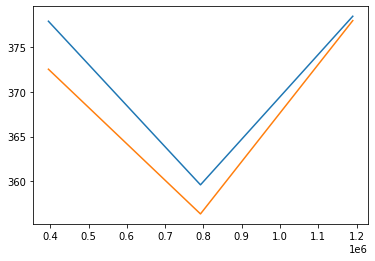

(Worker pid=35646) 2 1300 448.8058046650588
(Worker pid=35642) 25 1400 451.7041968321587
(Worker pid=35643) 26 1400 450.24952541184246
(Worker pid=35647) 53 1300 447.8185926253442
(Worker pid=35648) 64 1300 440.7843073382794
(Worker pid=35645) 23 1300 449.8897392313954
(Worker pid=35649) 5 1300 442.6172578403848
(Worker pid=35646) 25 1400 449.8408670117511
(Worker pid=35644) 63 1300 448.0826383982193
(Worker pid=35642) 26 1500 452.88201552189366
(Worker pid=35643) 63 1500 452.6381141043315
(Worker pid=35647) 49 1400 449.25958964227436
(Worker pid=35645) 50 1400 451.12888882347545
(Worker pid=35649) 42 1400 444.0810904203714
(Worker pid=35648) 12 1400 442.382780535575
(Worker pid=35646) 48 1500 450.7398507183797
(Worker pid=35644) 24 1400 448.94596561271186
(Worker pid=35642) 4 1600 454.02116342405515
(Worker pid=35643) 39 1600 453.6869599252571


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:406.711
Test:404.719
(Worker pid=35647) 63 1500 450.96412890425785
(Worker pid=35645) 5 1500 452.83647045117965
(Worker pid=35648) 26 1500 444.78637585774715
(Worker pid=35646) 48 1600 452.10271036486324
(Worker pid=35649) 13 1500 445.15337776720685
(Worker pid=35644) 5 1500 451.01731073733026
(Worker pid=35642) 49 1700 454.584730890691
(Worker pid=35643) 21 1700 454.68407133827657


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 6 1600 454.5412037402225
(Worker pid=35647) 11 1600 452.6260881669449
(Worker pid=35648) 62 1600 447.26737603965717
(Worker pid=35646) 21 1700 453.53532540173495
(Worker pid=35644) 39 1600 452.3003908118803
(Worker pid=35649) 25 1600 446.32202981669593
(Worker pid=35642) 57 1800 455.8170159947413
(Worker pid=35643) 15 1800 455.8410859401482
(Worker pid=35645) 64 1700 456.53225641814663
(Worker pid=35648) 53 1700 448.8970452206023
(Worker pid=35647) 56 1700 455.1562094500116
(Worker pid=35646) 62 1800 454.68947601399594
(Worker pid=35642) 52 1900 456.8447698393202
(Worker pid=35644) 18 1700 453.9587710931921
(Worker pid=35649) 5 1700 449.87457765016757
(Worker pid=35643) 69 1900 456.43465069808855
(Worker pid=35645) 22 1800 457.98170778028384
(Worker pid=35646) 3 1900 456.2662506867496
(Worker pid=35647) 45 1800 458.1675131762869
(Worker pid=35648) 5 1800 453.33155305266274
(Worker pid=35642) 24 2000 458.52311935962035
(Worker pid=35643) 9 2000 458.7074288671116
(Work

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 4 2100 461.2053151914715
(Worker pid=35643) 50 2200 462.7163681481478
(Worker pid=35647) 63 2000 461.6752680074422
(Worker pid=35642) 21 2200 462.7268925572058
(Worker pid=35645) 2 2000 463.6478595230709
(Worker pid=35648) 2 2000 458.9203788419342
(Worker pid=35649) 37 2000 458.54337615891404
(Worker pid=35644) 50 2000 464.0887862256853
(Worker pid=35643) 40 2300 466.42043819825454
(Worker pid=35646) 61 2200 463.28267656467864
(Worker pid=35647) 22 2100 464.3258201169634
(Worker pid=35645) 14 2100 465.98189863133274
(Worker pid=35642) 3 2300 465.15553841954244
(Worker pid=35648) 9 2100 461.4605578787777
(Worker pid=35649) 45 2100 462.3815020996391
(Worker pid=35644) 41 2100 465.46820396750513
(Worker pid=35646) 64 2300 466.24534795765214
(Worker pid=35643) 5 2400 467.7183593841671
(Worker pid=35645) 64 2200 468.31692069252927
(Worker pid=35647) 37 2200 467.5750666011652
(Worker pid=35642) 33 2400 466.5590352926481
Train:454.86
Test:458.998
(Worker pid=35648) 44 2200 

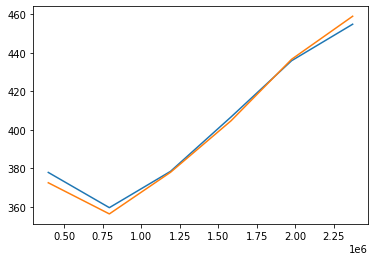

(Worker pid=35646) 38 2600 471.655251576391
(Worker pid=35642) 42 2700 472.26149938894616
(Worker pid=35645) 56 2500 472.8746926456614
(Worker pid=35647) 10 2500 473.49768734419257
(Worker pid=35644) 4 2500 472.4791508770716
(Worker pid=35648) 61 2500 471.03868375596795
(Worker pid=35643) 24 2800 474.1828466097735
(Worker pid=35649) 53 2500 471.86542738987845
(Worker pid=35642) 43 2800 474.1583600159838
(Worker pid=35646) 1 2700 473.7995828068114
(Worker pid=35645) 34 2600 474.68307717868396
Train:462.85
Test:468.372
(Worker pid=35647) 19 2600 475.47950576036266
(Worker pid=35643) 62 2900 475.3021129770331
(Worker pid=35648) 45 2600 474.70561169032516
(Worker pid=35644) 37 2600 474.5844738078606
(Worker pid=35649) 36 2600 473.9008935201979
(Worker pid=35642) 52 2900 475.5779835448558
(Worker pid=35646) 63 2800 475.1293266751395
(Worker pid=35645) 34 2700 475.9574450264328
(Worker pid=35647) 14 2700 476.8896440171747
(Worker pid=35643) 37 3000 476.60721519619943


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35648) 35 2700 475.5241864376758
(Worker pid=35644) 38 2700 475.95908120410803
(Worker pid=35649) 62 2700 476.5373162119874
(Worker pid=35642) 55 3000 476.424347217337
(Worker pid=35646) 45 2900 476.6890117400508
(Worker pid=35643) 34 3100 477.1296065553766
(Worker pid=35645) 47 2800 477.2704876926656
(Worker pid=35647) 66 2800 478.46218070225234
(Worker pid=35648) 38 2800 477.36874389412407
(Worker pid=35644) 46 2800 476.84763348043145
(Worker pid=35649) 9 2800 477.2791536881313
(Worker pid=35642) 17 3100 477.6389380047742
(Worker pid=35643) 65 3200 477.9682763570142
(Worker pid=35646) 42 3000 477.93698192470225
(Worker pid=35647) 58 2900 479.34558248984166
(Worker pid=35645) 63 2900 478.4340424549457
(Worker pid=35648) 21 2900 479.12082163514395
(Worker pid=35644) 27 2900 478.0080489176549
(Worker pid=35649) 63 2900 478.8702510284814
(Worker pid=35642) 6 3200 478.75505825474755
Train:468.649
Test:473.63
(Worker pid=35643) 23 3300 479.0667014611418
(Worker pid=35646) 37 31

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:471.136
Test:476.582
(Worker pid=35643) 17 3700 482.4125306805827
(Worker pid=35649) 55 3300 482.1050584135806
(Worker pid=35646) 10 3500 482.60374184015956
(Worker pid=35645) 59 3400 483.1785157426373
(Worker pid=35648) 61 3400 482.8565762981785
(Worker pid=35642) 1 3700 483.51957150783585
(Worker pid=35644) 68 3400 482.22343913541295
(Worker pid=35647) 57 3400 483.0955746020094
(Worker pid=35643) 67 3800 483.3024360265951
(Worker pid=35649) 7 3400 482.2952958322762
(Worker pid=35646) 41 3600 483.40231541088275
(Worker pid=35645) 23 3500 483.8972123693804
(Worker pid=35642) 63 3800 483.9655528810417
(Worker pid=35648) 68 3500 483.00771740829714
(Worker pid=35644) 20 3500 482.9681218842188
(Worker pid=35643) 27 3900 483.477686917013
(Worker pid=35647) 36 3500 483.7807354193766
(Worker pid=35649) 17 3500 483.06402131420845
(Worker pid=35645) 10 3600 484.15075293829256
(Worker pid=35646) 63 3700 483.74589592165796
(Worker pid=35642) 36 3900 484.4947900737225
(Worker pid=35643) 48 4

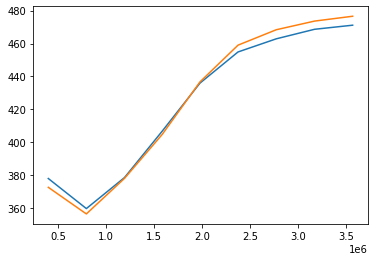

Train:473.016
Test:478.699
(Worker pid=35647) 21 3700 484.4720797564765
(Worker pid=35648) 11 3700 484.15136280060034
(Worker pid=35644) 66 3700 484.24298497404817
(Worker pid=35649) 35 3700 484.00567224020205
(Worker pid=35646) 43 3900 484.9432357870636
(Worker pid=35645) 44 3800 485.3771414513839
(Worker pid=35643) 58 4200 484.85417519264456
(Worker pid=35642) 36 4100 485.29852553678484
(Worker pid=35647) 67 3800 484.7292850905229
(Worker pid=35648) 55 3800 485.0568764291844
(Worker pid=35644) 67 3800 485.1071700184218
(Worker pid=35649) 50 3800 484.6488236390576
(Worker pid=35645) 11 3900 485.63135459637334
(Worker pid=35646) 69 4000 485.3264539125466
(Worker pid=35643) 62 4300 485.5298484109968
(Worker pid=35642) 48 4200 486.1694934210835
(Worker pid=35647) 49 3900 485.22891031590353
(Worker pid=35648) 15 3900 485.31966213038237
(Worker pid=35644) 45 3900 485.6570162465325
(Worker pid=35649) 64 3900 485.5160655853793
(Worker pid=35645) 58 4000 485.8642028785832
(Worker pid=35646) 4

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:475.419
Test:481.0
(Worker pid=35642) 62 4800 488.54095445225073
(Worker pid=35646) 8 4600 488.04073945212053
(Worker pid=35649) 10 4400 487.3865839057007
(Worker pid=35647) 12 4500 488.4585792381454
(Worker pid=35644) 8 4500 488.63999671619
(Worker pid=35648) 55 4500 488.5001929314091
(Worker pid=35643) 25 5000 488.8459642732543
(Worker pid=35645) 1 4600 488.6855408324168
(Worker pid=35642) 40 4900 488.73328413960166
(Worker pid=35646) 19 4700 488.27441250439887
(Worker pid=35649) 43 4500 487.68316860967235
(Worker pid=35644) 5 4600 488.9034128392449
(Worker pid=35647) 6 4600 489.2709482304572
(Worker pid=35648) 62 4600 488.9078870145021
(Worker pid=35643) 43 5100 489.50079393323364
(Worker pid=35645) 11 4700 489.3692365268632
(Worker pid=35642) 57 5000 489.4223520215301
(Worker pid=35646) 5 4800 488.7026670498546
(Worker pid=35649) 8 4600 488.1612482177719
(Worker pid=35644) 38 4700 489.1868605066776
(Worker pid=35643) 59 5200 489.994216786861
(Worker pid=35647) 6 4700 489.8131

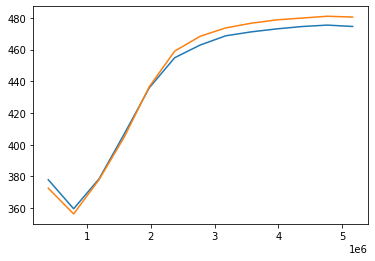

(Worker pid=35646) 29 5100 489.9975628597661
(Worker pid=35643) 14 5500 491.57368718947276
(Worker pid=35649) 17 4900 489.3746899786785
(Worker pid=35644) 50 5000 491.0579331245263
(Worker pid=35642) 31 5400 491.14475650491534
(Worker pid=35647) 30 5000 491.16101645331855
(Worker pid=35648) 3 5000 491.2310534567317
(Worker pid=35645) 42 5100 490.81620155959297
(Worker pid=35646) 42 5200 490.54282515010897
(Worker pid=35643) 68 5600 491.986787848041
(Worker pid=35649) 43 5000 490.0122985584341
(Worker pid=35642) 58 5500 491.6128114154305
(Worker pid=35644) 2 5100 491.5171742359612
(Worker pid=35648) 51 5100 491.50951188241993
(Worker pid=35647) 54 5100 491.51751698408367
(Worker pid=35645) 66 5200 491.07421735782754
(Worker pid=35643) 18 5700 492.084911408273
(Worker pid=35646) 40 5300 490.96179242862513
(Worker pid=35642) 10 5600 491.99187605849926
Train:473.229
Test:479.282
(Worker pid=35649) 7 5100 490.6595611965974
(Worker pid=35644) 6 5200 491.9864764714706
(Worker pid=35648) 43 52

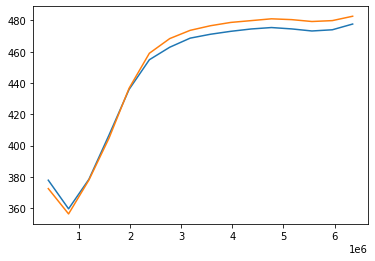

(Worker pid=35644) 12 6200 495.8747810773492
(Worker pid=35647) 20 6200 496.20271123886664
(Worker pid=35648) 23 6200 495.54836118239984
(Worker pid=35642) 10 6700 495.4065335692052
(Worker pid=35649) 60 6100 494.6244741603704
(Worker pid=35643) 46 6900 495.7122632054454
(Worker pid=35646) 66 6400 495.7841796383695
(Worker pid=35645) 14 6300 496.11319595689
(Worker pid=35647) 9 6300 496.6406759145526
(Worker pid=35644) 1 6300 496.060874349405
Train:480.182
Test:485.338
(Worker pid=35642) 12 6800 495.73882982976295
(Worker pid=35648) 30 6300 495.6778238657374
(Worker pid=35643) 56 7000 495.99436937247697
(Worker pid=35649) 28 6200 494.72646144073735
(Worker pid=35645) 65 6400 496.20042417010364
(Worker pid=35646) 27 6500 495.99385355847386
(Worker pid=35644) 65 6400 496.48716902876964
(Worker pid=35647) 60 6400 496.9157289855639
(Worker pid=35642) 61 6900 495.89151961811234
(Worker pid=35643) 16 7100 496.34364993076855
(Worker pid=35648) 11 6400 496.00450090746153
(Worker pid=35649) 62 

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 28 6600 496.6162288206532
(Worker pid=35644) 45 6600 496.67049438455683
(Worker pid=35647) 46 6600 497.09260554643106
(Worker pid=35643) 30 7300 496.3987840071667
(Worker pid=35648) 30 6600 496.4085079202405
(Worker pid=35642) 24 7100 496.7217278266663
(Worker pid=35649) 15 6500 495.27141800114725
(Worker pid=35645) 24 6700 496.7468061008339
(Worker pid=35646) 13 6800 496.6748086635119
Train:482.096
Test:487.801
(Worker pid=35644) 33 6700 497.0601966912752
(Worker pid=35643) 58 7400 496.68227119679494
(Worker pid=35647) 64 6700 497.4282923660267
(Worker pid=35642) 13 7200 496.77136230685124
(Worker pid=35648) 13 6700 496.5441322178656
(Worker pid=35649) 27 6600 495.55899873888035
(Worker pid=35645) 28 6800 497.03378387430024
(Worker pid=35646) 42 6900 496.7928876450228
(Worker pid=35643) 31 7500 496.86493147949056
(Worker pid=35644) 26 6800 497.0601966912752
(Worker pid=35647) 54 6800 497.43739250598895
(Worker pid=35642) 38 7300 496.80910485580046
(Worker pid=35648)

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


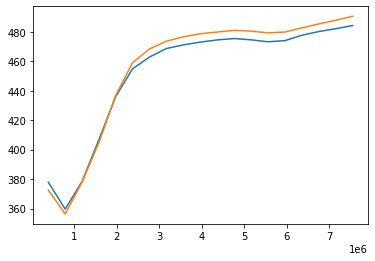

Train:485.35
Test:492.541
(Worker pid=35646) 3 7600 498.68445768608194
(Worker pid=35649) 19 7300 498.15859207950933
(Worker pid=35645) 68 7500 498.42838628594245
(Worker pid=35642) 3 8000 498.26970628522633
(Worker pid=35644) 55 7500 498.6869296124861
(Worker pid=35647) 38 7500 498.5349015542725
(Worker pid=35643) 22 8300 498.41745061889867
(Worker pid=35648) 39 7500 498.08311963610925
(Worker pid=35646) 12 7700 498.9283730527098
(Worker pid=35649) 18 7400 498.3039947791983
(Worker pid=35645) 22 7600 498.61766406258687
(Worker pid=35642) 24 8100 498.70053791446367
(Worker pid=35647) 18 7600 498.75911324213325
(Worker pid=35644) 17 7600 498.93398069680416
(Worker pid=35643) 60 8400 498.67559257724344
(Worker pid=35648) 62 7600 498.3755783663816
(Worker pid=35646) 63 7800 499.1885626174064
(Worker pid=35645) 33 7700 498.9588546883433
(Worker pid=35649) 1 7500 498.33878198623364
(Worker pid=35642) 2 8200 498.8092457119521
(Worker pid=35643) 18 8500 498.83489244376045
(Worker pid=35644) 3

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:486.312
Test:494.555
(Worker pid=35644) 12 8200 500.72315635557993
(Worker pid=35649) 7 8000 499.8654040692251
(Worker pid=35646) 13 8400 500.3979432596686
(Worker pid=35642) 14 8800 500.04179079575175
(Worker pid=35647) 43 8200 500.5867134927563
(Worker pid=35648) 22 8200 499.4591128519438
(Worker pid=35643) 33 9100 499.95685062126296
(Worker pid=35645) 9 8300 499.8503350128081
(Worker pid=35644) 59 8300 501.23393191617504


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 61 8500 500.4038330387208
(Worker pid=35649) 40 8100 500.2362224026232
(Worker pid=35642) 54 8900 500.1348166383198
(Worker pid=35647) 68 8300 500.68751897658615
(Worker pid=35643) 7 9200 500.2490836443399
(Worker pid=35648) 44 8300 499.86449153523273
(Worker pid=35645) 44 8400 500.1742495534725
(Worker pid=35644) 65 8400 501.5115521957362
(Worker pid=35642) 50 9000 500.4170349431927
(Worker pid=35647) 64 8400 500.71605489769405
(Worker pid=35643) 59 9300 500.4175032644775
(Worker pid=35646) 32 8600 500.5217523427546
(Worker pid=35649) 59 8200 500.7219065133474
(Worker pid=35645) 13 8500 500.26945656609354
(Worker pid=35648) 63 8400 499.9519458066884
(Worker pid=35644) 57 8500 501.7531201570326
(Worker pid=35642) 37 9100 500.7471898449315
(Worker pid=35643) 69 9400 500.5595913049696
(Worker pid=35647) 14 8500 500.95664606025406
(Worker pid=35649) 59 8300 501.06986239866364
(Worker pid=35646) 63 8700 500.7230625457857
(Worker pid=35645) 60 8600 500.5003941089462
(Work

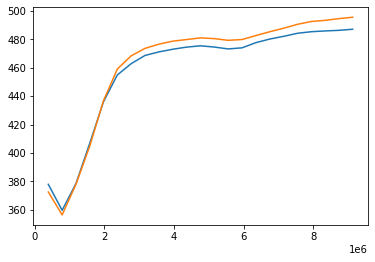

(Worker pid=35643) 15 9600 500.83335054696937
(Worker pid=35644) 17 8700 501.9963484565637
(Worker pid=35642) 57 9300 501.4945234275739
(Worker pid=35647) 27 8700 501.50769311521947
(Worker pid=35646) 70 8900 501.19600241516287
(Worker pid=35649) 25 8500 501.553073210194
(Worker pid=35648) 6 8700 501.06766668638676
(Worker pid=35645) 58 8800 500.7068508909254
(Worker pid=35643) 69 9700 501.0189024731163
(Worker pid=35644) 38 8800 502.15110620813783
(Worker pid=35642) 51 9400 501.58453537154315
(Worker pid=35647) 44 8800 501.6166565127791
(Worker pid=35646) 27 9000 501.19600241516287
(Worker pid=35648) 55 8800 501.28110726313867
(Worker pid=35649) 2 8600 501.79700670406163
(Worker pid=35645) 67 8900 500.95493309862377
(Worker pid=35643) 29 9800 501.0189024731163
(Worker pid=35642) 59 9500 501.71041243477913
(Worker pid=35644) 49 8900 502.3126937114928
(Worker pid=35647) 23 8900 501.66493916294036
Train:484.802
Test:493.995
(Worker pid=35646) 47 9100 501.3678385902143
(Worker pid=35648) 

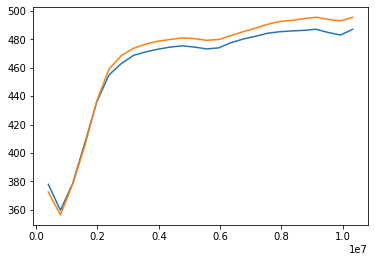

(Worker pid=35645) 30 10000 502.3068307454598
(Worker pid=35649) 18 9700 503.4878910932135
(Worker pid=35642) 45 10600 503.2076646167153
(Worker pid=35643) 62 11000 502.9075702686295
(Worker pid=35648) 8 9900 502.3701310496961
(Worker pid=35644) 45 10000 503.6050840074575
(Worker pid=35647) 5 10000 503.0054729699632
(Worker pid=35646) 56 10200 502.85811252695305
(Worker pid=35645) 17 10100 502.43506532908816
(Worker pid=35642) 40 10700 503.293502046623
(Worker pid=35649) 6 9800 503.5908282617904
Train:488.771
Test:496.377
(Worker pid=35643) 67 11100 503.2607562942286
(Worker pid=35648) 68 10000 502.3701310496961
(Worker pid=35644) 70 10100 503.62840657180305
(Worker pid=35647) 10 10100 503.1510091525755
(Worker pid=35645) 30 10200 502.55690966898527
(Worker pid=35646) 20 10300 502.9869965026938
(Worker pid=35643) 66 11200 503.31340817184036
(Worker pid=35642) 67 10800 503.35202883523016
(Worker pid=35649) 9 9900 503.69594586649464
(Worker pid=35648) 50 10100 502.56666023058756
(Worker 

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 38 10400 502.70025591396717
(Worker pid=35644) 31 10300 503.7154634317761
(Worker pid=35647) 68 10300 503.3733248810155
(Worker pid=35646) 23 10500 503.2489040376607
(Worker pid=35642) 42 11000 503.66245452266696
(Worker pid=35643) 69 11400 503.59495095524323
(Worker pid=35649) 23 10100 503.867395118041
(Worker pid=35648) 25 10300 503.39871221861614
(Worker pid=35644) 67 10400 503.77827538673944
(Worker pid=35645) 6 10500 502.71349344345924
(Worker pid=35646) 18 10600 503.3855912242251
(Worker pid=35647) 41 10400 503.51918532825147
(Worker pid=35643) 30 11500 503.64645975615036
Train:489.004
Test:496.669
(Worker pid=35642) 9 11100 503.7395337851311
(Worker pid=35649) 7 10200 503.9006758417638
(Worker pid=35648) 12 10400 503.5893445824193
(Worker pid=35644) 22 10500 503.81058202963936
(Worker pid=35642) 48 11200 503.8938207392402
(Worker pid=35645) 51 10600 502.8008290287531
(Worker pid=35646) 13 10700 503.6532301084413
(Worker pid=35643) 51 11600 503.75246741525854
(

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35649) 67 10300 504.1350520627678
(Worker pid=35648) 53 10500 503.66984561331657
(Worker pid=35642) 26 11300 503.9110800324593
(Worker pid=35643) 65 11700 503.75246741525854
(Worker pid=35644) 26 10600 503.84827098296967
(Worker pid=35645) 11 10700 503.02207813712096
(Worker pid=35646) 17 10800 503.791334837757
(Worker pid=35647) 42 10600 503.80147984311253
(Worker pid=35649) 31 10400 504.1350520627678
(Worker pid=35648) 36 10600 503.66984561331657
(Worker pid=35643) 51 11800 503.75246741525854
(Worker pid=35642) 45 11400 503.92224235952057
(Worker pid=35644) 32 10700 503.89098379261424
(Worker pid=35646) 61 10900 504.04876853153286
(Worker pid=35645) 28 10800 503.08006961646566
(Worker pid=35647) 6 10700 503.95537301336515
(Worker pid=35648) 7 10700 503.6966745551136
(Worker pid=35649) 48 10500 504.30697484193337
(Worker pid=35642) 66 11500 504.0283469026851
(Worker pid=35643) 23 11900 503.82483063637255
(Worker pid=35644) 54 10800 503.97245838507337
Train:489.593
Test:497

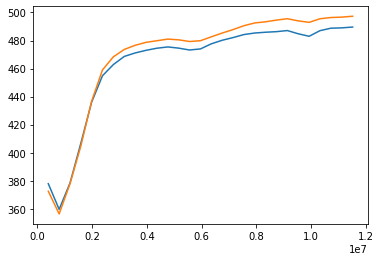

Train:490.7
Test:498.194
(Worker pid=35648) 60 11100 504.1482843435142
(Worker pid=35649) 61 10900 504.78212641658183
(Worker pid=35645) 50 11300 503.6272383630237
(Worker pid=35646) 45 11400 504.65067506281815
(Worker pid=35644) 66 11200 504.0216421323521
(Worker pid=35643) 19 12400 504.12382214660505
(Worker pid=35647) 48 11200 504.1555693178504
(Worker pid=35642) 42 12000 504.8091637564326
(Worker pid=35648) 36 11200 504.36565196183716
(Worker pid=35649) 37 11000 504.78212641658183
(Worker pid=35646) 37 11500 504.76798098465173
(Worker pid=35645) 56 11400 503.78382282411974
(Worker pid=35643) 40 12500 504.38813977135953
(Worker pid=35644) 69 11300 504.03226679482367
(Worker pid=35647) 66 11300 504.4813359428397
(Worker pid=35642) 31 12100 504.95096767572363
(Worker pid=35648) 35 11300 504.6025926857191
(Worker pid=35646) 13 11600 504.82503811927154
(Worker pid=35645) 21 11500 503.9016063411721
(Worker pid=35649) 8 11100 505.0217283316912
(Worker pid=35643) 30 12600 504.5379669703164

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:487.668
Test:496.665
(Worker pid=35649) 65 11600 505.6060399777863
(Worker pid=35644) 3 11900 504.9980653835209
(Worker pid=35647) 25 11900 505.5352619892327
(Worker pid=35643) 68 13200 505.410892200621
(Worker pid=35646) 53 12200 505.58111702199574
(Worker pid=35645) 6 12100 504.50746103823093
(Worker pid=35642) 52 12800 505.486224647902
(Worker pid=35648) 26 11900 505.4600938931355
(Worker pid=35649) 33 11700 505.86282275115633
(Worker pid=35644) 70 12000 505.08027480046064
(Worker pid=35647) 61 12000 505.7648912510355
(Worker pid=35643) 41 13300 505.4414539954809
(Worker pid=35646) 13 12300 505.80479756138135
(Worker pid=35645) 53 12200 504.8717117827765
(Worker pid=35642) 33 12900 505.60566087737357
(Worker pid=35648) 54 12000 505.7312010473205
(Worker pid=35649) 25 11800 505.87069819591426
(Worker pid=35644) 15 12100 505.3726686519506
(Worker pid=35643) 54 13400 505.59277619945476
(Worker pid=35647) 58 12100 506.25949030897516


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 8 12300 504.9741156528756
(Worker pid=35646) 28 12400 506.0183380806954
(Worker pid=35642) 64 13000 506.05079053766156
(Worker pid=35648) 40 12100 506.0386230395126
(Worker pid=35649) 24 11900 505.91324589395026
(Worker pid=35643) 22 13500 505.7476517674219
(Worker pid=35644) 30 12200 505.43906271505006
(Worker pid=35647) 27 12200 506.35945119824976
(Worker pid=35642) 62 13100 506.0668180015748
Train:486.173
Test:494.773
(Worker pid=35646) 9 12500 506.2652735286277
(Worker pid=35645) 3 12400 505.1554182465583
(Worker pid=35648) 17 12200 506.1251881436054
(Worker pid=35643) 18 13600 505.8373792231511
(Worker pid=35644) 18 12300 505.687990934093
(Worker pid=35649) 58 12000 506.1947102349209
(Worker pid=35647) 34 12300 506.383829100267
(Worker pid=35642) 42 13200 506.3447503952608
(Worker pid=35646) 66 12600 506.4526554598303
(Worker pid=35645) 57 12500 505.4437495672649
(Worker pid=35648) 38 12300 506.3900798020137
/home/mbyx3tk2/ray_results/ES_CropEnv_2022-03-14_12-29

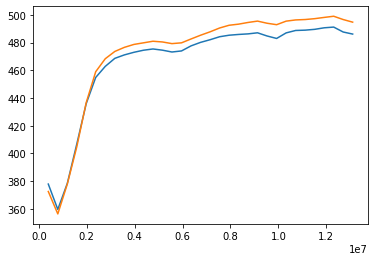

(Worker pid=35644) 67 12400 505.81625315288215
(Worker pid=35647) 6 12400 506.5265965233613
(Worker pid=35649) 2 12100 506.22199411588093
(Worker pid=35646) 19 12700 506.482274454234
(Worker pid=35642) 10 13300 506.46616165090893
(Worker pid=35645) 46 12600 505.76117371020354
(Worker pid=35644) 68 12500 505.9029122251924
(Worker pid=35648) 58 12400 506.70097290631935
(Worker pid=35643) 32 13800 506.3860752787837
(Worker pid=35649) 29 12200 506.33830667397893
(Worker pid=35647) 54 12500 506.80590574079804
(Worker pid=35646) 11 12800 506.482274454234
(Worker pid=35642) 67 13400 506.5486654636787
(Worker pid=35645) 63 12700 505.7903551190177
(Worker pid=35643) 40 13900 506.44987738756237
(Worker pid=35644) 19 12600 505.95190502330684
(Worker pid=35648) 17 12500 506.78572597936386
(Worker pid=35649) 54 12300 506.39172038220175
(Worker pid=35647) 26 12600 506.81903068351176


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:490.082
Test:497.8
(Worker pid=35646) 16 12900 506.64339564549965
(Worker pid=35642) 58 13500 506.5665670415081
(Worker pid=35645) 5 12800 505.9336307749945
(Worker pid=35643) 66 14000 506.52669235262334
(Worker pid=35648) 17 12600 506.78572597936386
(Worker pid=35644) 13 12700 506.01178905586835
(Worker pid=35649) 31 12400 506.53585743662677
(Worker pid=35647) 59 12700 506.8430218427774
(Worker pid=35642) 45 13600 506.64942253911306
(Worker pid=35646) 49 13000 507.0509648491968
(Worker pid=35643) 18 14100 506.77881917999764
(Worker pid=35645) 47 12900 506.09459684166256
(Worker pid=35648) 62 12700 506.8306964436158
(Worker pid=35644) 52 12800 506.14662091155
(Worker pid=35649) 8 12500 506.72198359996173
(Worker pid=35647) 34 12800 506.8745521863828
(Worker pid=35642) 37 13700 506.7309872399847
(Worker pid=35646) 57 13100 507.2685620238478
(Worker pid=35643) 59 14200 506.81390244971055
(Worker pid=35645) 50 13000 506.1386851244369
(Worker pid=35648) 47 12800 506.8752323821564
(Wo

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 40 13400 507.70064487626047
(Worker pid=35645) 3 13300 506.52302764169747
(Worker pid=35644) 42 13200 506.9486740511266
(Worker pid=35648) 42 13100 507.05556347109854
(Worker pid=35642) 31 14100 507.0061754601491
(Worker pid=35643) 3 14600 507.24500506731096
(Worker pid=35649) 13 12900 507.11794294915586
(Worker pid=35646) 30 13500 507.850763795728
(Worker pid=35647) 20 13200 507.07674160121906
(Worker pid=35645) 22 13400 506.5630813601555
(Worker pid=35648) 5 13200 507.24086083363176
(Worker pid=35644) 48 13300 506.9486740511266
(Worker pid=35642) 70 14200 507.08265068265683
(Worker pid=35643) 10 14700 507.2576795768892
(Worker pid=35649) 9 13000 507.1408485308324
(Worker pid=35646) 57 13600 507.85769972686904
(Worker pid=35647) 27 13300 507.31557511534794
(Worker pid=35645) 32 13500 506.62048069667145
(Worker pid=35644) 66 13400 506.9692016270839
(Worker pid=35648) 14 13300 507.43760761718875
Train:494.808
Test:501.261
(Worker pid=35642) 29 14300 507.0980387940829


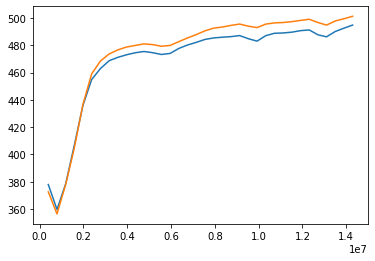

(Worker pid=35647) 21 13600 507.6512881471734
(Worker pid=35645) 42 13800 507.2888900936502
(Worker pid=35649) 35 13300 507.4700532088072
(Worker pid=35644) 27 13700 507.4267129995504
(Worker pid=35643) 3 15100 508.0308189866575
(Worker pid=35648) 60 13600 507.8445259350768
(Worker pid=35642) 29 14600 507.5655189564391
(Worker pid=35646) 38 14000 508.4238352025553
(Worker pid=35647) 44 13700 507.7958770825914
(Worker pid=35645) 23 13900 507.49261932888373
Train:494.847
Test:502.1
(Worker pid=35649) 61 13400 507.54858489205
(Worker pid=35644) 34 13800 507.6558503659102
(Worker pid=35643) 50 15200 508.1785876304989
(Worker pid=35642) 5 14700 507.8370945184352
(Worker pid=35646) 19 14100 508.67470656009255
(Worker pid=35648) 54 13700 507.9494663897207
(Worker pid=35645) 64 14000 507.4980669561819
(Worker pid=35647) 49 13800 507.87186481709256
(Worker pid=35649) 37 13500 507.6622624386995
(Worker pid=35644) 13 13900 507.81709795995357
(Worker pid=35643) 63 15300 508.19323393272526
(Worker 

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35647) 8 14700 509.16716695620426
(Worker pid=35643) 21 16300 509.53623347096953
(Worker pid=35646) 52 15100 509.8578085992404
(Worker pid=35649) 10 14400 509.2920881017453
(Worker pid=35644) 1 14800 509.0014611640865
(Worker pid=35642) 64 15800 509.03343021653177
(Worker pid=35648) 34 14700 509.0187020994081
(Worker pid=35645) 30 15000 509.0185733381468
(Worker pid=35647) 1 14800 509.31623231170533
(Worker pid=35643) 6 16400 509.60732872992145
(Worker pid=35646) 28 15200 509.9497901380664
/home/mbyx3tk2/ray_results/ES_CropEnv_2022-03-14_12-29-19pwehz54t/checkpoint_000120/checkpoint-120


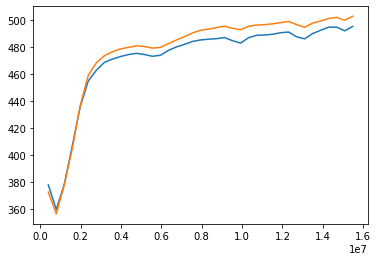

Train:496.989
Test:503.458
(Worker pid=35642) 12 15900 509.22432449665337
(Worker pid=35649) 55 14500 509.4511900176398
(Worker pid=35644) 37 14900 509.2447053587139
(Worker pid=35648) 35 14800 509.06491824464445
(Worker pid=35643) 21 16500 509.69327740776953
(Worker pid=35647) 68 14900 509.37173522381545
(Worker pid=35645) 54 15100 509.1514781583481
(Worker pid=35646) 4 15300 510.0790223536518
(Worker pid=35642) 47 16000 509.4894294087008
(Worker pid=35644) 41 15000 509.2715790370041
(Worker pid=35649) 26 14600 509.67152422469775
(Worker pid=35648) 13 14900 509.3784713282379
(Worker pid=35643) 20 16600 509.8672079134456
(Worker pid=35647) 45 15000 509.56055517244386
(Worker pid=35645) 22 15200 509.39541723081015
(Worker pid=35646) 57 15400 510.27477644715816
(Worker pid=35642) 30 16100 509.63571673386156
(Worker pid=35644) 20 15100 509.3139168166171
(Worker pid=35648) 32 15000 509.49722568683626
(Worker pid=35649) 25 14700 509.9046343762108
(Worker pid=35643) 22 16700 510.006634501755

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35643) 31 17000 510.2141004607763
(Worker pid=35649) 11 15000 510.22258068587416
(Worker pid=35644) 8 15400 509.7308800234293
(Worker pid=35648) 26 15300 509.69920154513426
(Worker pid=35646) 41 15800 510.67092242228466
(Worker pid=35642) 56 16500 510.16750895248373
(Worker pid=35647) 68 15400 510.1507049021021
(Worker pid=35645) 68 15600 509.8511422785101
(Worker pid=35643) 16 17100 510.2141004607763
(Worker pid=35649) 23 15100 510.2522704329378
(Worker pid=35648) 13 15400 509.9822992915797
(Worker pid=35644) 24 15500 509.9013682734897
(Worker pid=35642) 65 16600 510.2699659077513
(Worker pid=35646) 38 15900 510.74750245763113
(Worker pid=35647) 5 15500 510.17326210921027
(Worker pid=35645) 66 15700 509.9004276466473
(Worker pid=35643) 3 17200 510.3468337534821
(Worker pid=35649) 58 15200 510.34595157954476
(Worker pid=35644) 64 15600 509.9013682734897
Train:494.567
Test:502.738
(Worker pid=35648) 24 15500 510.0791540953522
(Worker pid=35642) 59 16700 510.3522240491052
(Wo

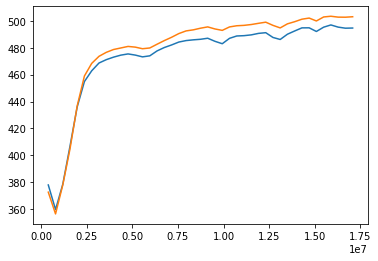

(Worker pid=35644) 11 16100 510.2948571698254
(Worker pid=35643) 62 17800 510.55861257694403
(Worker pid=35646) 30 16500 511.12563346909405
(Worker pid=35649) 31 15700 510.7122793796852
(Worker pid=35647) 4 16100 510.6051231823135
(Worker pid=35645) 51 16300 510.54071694556205
(Worker pid=35642) 41 17300 510.6298130570103
(Worker pid=35643) 50 17900 510.62879438329026
(Worker pid=35644) 36 16200 510.40318709007346
(Worker pid=35648) 11 16100 510.3403442805527
(Worker pid=35646) 22 16600 511.1430467957452
(Worker pid=35647) 68 16200 510.71384497261283
(Worker pid=35649) 38 15800 510.74593439995834
(Worker pid=35645) 38 16400 510.59230482527636
(Worker pid=35642) 8 17400 510.6743548732781
(Worker pid=35643) 43 18000 510.64875487658634
(Worker pid=35644) 32 16300 510.5102662866573
(Worker pid=35648) 18 16200 510.36334244894493
(Worker pid=35646) 63 16700 511.1868625661225
(Worker pid=35649) 27 15900 510.7939558847928
(Worker pid=35647) 1 16300 510.740234173955


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:496.84
Test:504.042
(Worker pid=35645) 5 16500 510.6856922809866
(Worker pid=35642) 41 17500 510.7361213105456
(Worker pid=35643) 26 18100 510.664121033993
(Worker pid=35648) 48 16300 510.4484879123367
(Worker pid=35644) 66 16400 510.55883403129224
(Worker pid=35646) 35 16800 511.2946297747453
(Worker pid=35647) 16 16400 510.81247358134175
(Worker pid=35649) 48 16000 510.94526147745773
(Worker pid=35642) 4 17600 510.7741672887634
(Worker pid=35645) 4 16600 510.7393807364426
(Worker pid=35643) 15 18200 510.67187821236047
(Worker pid=35646) 56 16900 511.50910206928467
(Worker pid=35648) 22 16400 510.45796484887086
(Worker pid=35644) 39 16500 510.8931094555544
(Worker pid=35647) 3 16500 510.91401096192817
(Worker pid=35642) 42 17700 510.8423425209477
(Worker pid=35649) 68 16100 511.06397565275444
(Worker pid=35645) 70 16700 510.74829471296584
(Worker pid=35643) 43 18300 510.67187821236047


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 70 17000 511.6141819884562
(Worker pid=35644) 34 16600 510.8931094555544
(Worker pid=35648) 52 16500 510.53236020235846
(Worker pid=35647) 68 16600 510.94790335778305
(Worker pid=35642) 2 17800 510.86955115188465
(Worker pid=35649) 65 16200 511.09117861677953
(Worker pid=35643) 48 18400 510.67187821236047
(Worker pid=35645) 45 16800 510.76007060448404
(Worker pid=35646) 7 17100 511.6843286020731
(Worker pid=35644) 13 16700 510.8931094555544
(Worker pid=35648) 21 16600 510.55054285889264


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:497.499
Test:504.403
(Worker pid=35642) 45 17900 510.8811579517146
(Worker pid=35643) 53 18500 510.72219687372564
(Worker pid=35647) 27 16700 510.9710364499908
(Worker pid=35649) 67 16300 511.16706035193056
(Worker pid=35645) 56 16900 510.90235342956333
(Worker pid=35646) 24 17200 511.71637941254176
(Worker pid=35644) 16 16800 511.02694755284244
(Worker pid=35643) 63 18600 510.8204258996291
(Worker pid=35648) 15 16700 510.78419455187003
(Worker pid=35642) 19 18000 511.0340164339822
(Worker pid=35647) 37 16800 511.07180399483923
(Worker pid=35649) 15 16400 511.37920124528995
(Worker pid=35645) 70 17000 511.0282172888977
(Worker pid=35646) 35 17300 511.7196382338042
(Worker pid=35644) 54 16900 511.1161407893776
(Worker pid=35643) 67 18700 510.82590086178345
(Worker pid=35642) 47 18100 511.04596254024176
(Worker pid=35648) 48 16800 510.8490242612749
(Worker pid=35647) 27 16900 511.1010977120276
(Worker pid=35649) 16 16500 511.41521701551005
(Worker pid=35645) 18 17100 511.1423572323

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35648) 8 17100 511.05588670072734
(Worker pid=35647) 42 17200 511.55331367384883
(Worker pid=35649) 50 16800 511.683965354679
(Worker pid=35643) 48 19100 511.2877886422357
(Worker pid=35645) 53 17400 511.4288237340335
(Worker pid=35642) 62 18500 511.3137097006119
(Worker pid=35644) 31 17300 511.65918383852676
(Worker pid=35646) 25 17700 511.9401992493879
(Worker pid=35648) 22 17200 511.1045170341102
(Worker pid=35647) 52 17300 511.6147283131234
/home/mbyx3tk2/ray_results/ES_CropEnv_2022-03-14_12-29-19pwehz54t/checkpoint_000140/checkpoint-140


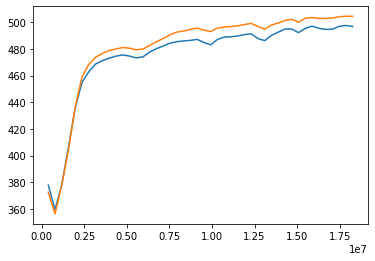

(Worker pid=35645) 68 17500 511.58130313540335
(Worker pid=35649) 37 16900 511.72794851387306
(Worker pid=35643) 25 19200 511.3716183528011
(Worker pid=35642) 69 18600 511.3401244066161
(Worker pid=35644) 36 17400 511.7238461928545
(Worker pid=35646) 63 17800 511.9425629216974
(Worker pid=35648) 3 17300 511.2005588935236
(Worker pid=35647) 67 17400 511.69887305893116
(Worker pid=35643) 25 19300 511.45983310675064
(Worker pid=35649) 23 17000 511.75131076908303
(Worker pid=35645) 35 17600 511.61932787948274
(Worker pid=35642) 42 18700 511.35054243460854
Train:495.197
Test:503.622
(Worker pid=35644) 53 17500 511.780098228896
(Worker pid=35646) 47 17900 511.9956139377813
(Worker pid=35648) 40 17400 511.28962921612805
(Worker pid=35643) 70 19400 511.5120224405852
(Worker pid=35647) 45 17500 511.7567537818542
(Worker pid=35649) 63 17100 511.7685851523417
(Worker pid=35644) 42 17600 511.7948621941505
(Worker pid=35645) 17 17700 511.6275037811104
(Worker pid=35642) 11 18800 511.3747678085615
(

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:495.621
Test:504.241
(Worker pid=35642) 54 19500 511.6060048075637
(Worker pid=35648) 55 18100 511.92049997691396
(Worker pid=35647) 69 18200 512.0348411175223
(Worker pid=35649) 62 17800 512.1860867106554
(Worker pid=35644) 58 18300 512.2493505342214
(Worker pid=35643) 43 20200 511.92851336113705
(Worker pid=35646) 65 18700 512.3161591722996
(Worker pid=35645) 21 18400 511.78202938512464
(Worker pid=35642) 12 19600 511.61305109883665


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35648) 7 18200 511.95263046340364
(Worker pid=35647) 3 18300 512.0348411175223
(Worker pid=35649) 62 17900 512.2456309770696
(Worker pid=35644) 8 18400 512.2867106657244
(Worker pid=35643) 43 20300 511.9987895882891
(Worker pid=35646) 23 18800 512.3670032729443
(Worker pid=35642) 4 19700 511.7433972473413
(Worker pid=35645) 23 18500 511.8018986478036
(Worker pid=35648) 58 18300 511.9645772846877
(Worker pid=35647) 63 18400 512.1315031460831
(Worker pid=35649) 67 18000 512.2559461170969
(Worker pid=35644) 45 18500 512.3297615626125
(Worker pid=35643) 40 20400 512.0722655735557
(Worker pid=35642) 52 19800 511.81283714450694
(Worker pid=35646) 63 18900 512.4169313578998
(Worker pid=35645) 19 18600 511.84914307513765
(Worker pid=35648) 2 18400 511.97995351306247
(Worker pid=35647) 1 18500 512.249665165816
(Worker pid=35643) 40 20500 512.0750801563266
(Worker pid=35649) 2 18100 512.3870351694615
(Worker pid=35642) 67 19900 511.82273312496045
(Worker pid=35644) 58 18600 512.51523

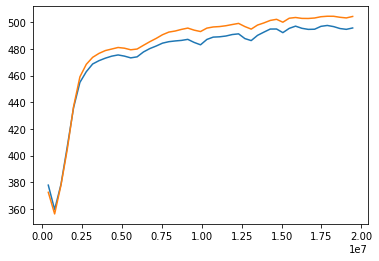

Train:496.703
Test:505.44
(Worker pid=35646) 23 19000 512.4355531267208
(Worker pid=35645) 20 18700 511.8502460964899
(Worker pid=35648) 52 18500 512.1321500844855
(Worker pid=35643) 10 20600 512.1831645910796
(Worker pid=35647) 7 18600 512.302168167756
(Worker pid=35642) 5 20000 511.96507819378155
(Worker pid=35649) 61 18200 512.4227525149794
(Worker pid=35644) 17 18700 512.5594712831106
(Worker pid=35646) 25 19100 512.5170169772728
(Worker pid=35645) 26 18800 511.96757039073316
(Worker pid=35648) 18 18600 512.1639527695354
(Worker pid=35643) 60 20700 512.2418040748621
(Worker pid=35647) 52 18700 512.3149250553281
(Worker pid=35642) 38 20100 512.0098134949789
(Worker pid=35644) 67 18800 512.6605249537246
(Worker pid=35649) 2 18300 512.5051911782917
(Worker pid=35646) 54 19200 512.5260273384314
(Worker pid=35645) 15 18900 512.0056569873432
(Worker pid=35643) 15 20800 512.313437031143
(Worker pid=35648) 26 18700 512.2214467871521
(Worker pid=35642) 17 20200 512.0988641936056
(Worker pid

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35647) 51 19400 512.6679049557526
(Worker pid=35643) 29 21500 512.9838119373919
(Worker pid=35649) 4 19000 512.81738643763
(Worker pid=35645) 57 19600 512.5716740057533
(Worker pid=35642) 15 20900 512.5221965923782
(Worker pid=35646) 53 19900 512.8129117712753
(Worker pid=35648) 70 19400 513.015140350167
(Worker pid=35644) 7 19600 513.0663546624711
(Worker pid=35643) 53 21600 513.0352409195598
(Worker pid=35647) 12 19500 512.8129870739207
(Worker pid=35649) 68 19100 512.8804836062019
(Worker pid=35642) 34 21000 512.5887487236236
(Worker pid=35645) 42 19700 512.5917233159525
(Worker pid=35646) 64 20000 512.8167922221522
(Worker pid=35648) 56 19500 513.2122297120465
(Worker pid=35644) 41 19700 513.0663546624711
(Worker pid=35643) 42 21700 513.1025885505062
(Worker pid=35647) 59 19600 512.9958222690627
(Worker pid=35649) 31 19200 512.8829462686376
(Worker pid=35642) 7 21100 512.6499008716747
Train:497.462
Test:506.522
(Worker pid=35646) 10 20100 512.8167922221522
(Worker pid=3

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


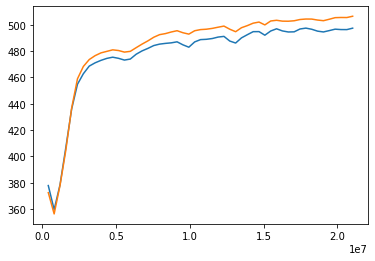

(Worker pid=35643) 23 21900 513.1082583121852
(Worker pid=35648) 52 19700 513.2998504272563
(Worker pid=35644) 62 19900 513.1801172394916
(Worker pid=35647) 61 19800 512.9958222690627
(Worker pid=35649) 3 19400 513.0342044991099
(Worker pid=35642) 62 21300 512.8200407650478
(Worker pid=35645) 5 20000 512.816047434835
(Worker pid=35646) 58 20300 513.0138050445123
(Worker pid=35643) 11 22000 513.1082583121852
(Worker pid=35648) 37 19800 513.3811792976038
(Worker pid=35644) 27 20000 513.2118176073482
(Worker pid=35647) 51 19900 513.0266601095655
(Worker pid=35642) 15 21400 512.8709257484414
(Worker pid=35649) 24 19500 513.0342044991099
(Worker pid=35645) 30 20100 512.816047434835
(Worker pid=35646) 5 20400 513.0480813329135
(Worker pid=35643) 23 22100 513.1082583121852
(Worker pid=35648) 9 19900 513.405177195563
(Worker pid=35644) 65 20100 513.2589547201891
(Worker pid=35647) 66 20000 513.0303376672678
(Worker pid=35642) 13 21500 512.8709257484414
Train:498.504
Test:506.998
(Worker pid=35

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 3 20600 513.0876631210197
(Worker pid=35649) 6 19700 513.1559114945386
(Worker pid=35645) 30 20300 512.9453863941436
(Worker pid=35643) 10 22300 513.1539472753902
(Worker pid=35648) 19 20100 513.5512774544566
(Worker pid=35644) 14 20300 513.2754155932247
(Worker pid=35642) 7 21700 512.8709257484414
(Worker pid=35647) 57 20200 513.0520835668231
(Worker pid=35643) 13 22400 513.202115955517
(Worker pid=35649) 41 19800 513.2186935360002
(Worker pid=35646) 58 20700 513.3021795808604
(Worker pid=35645) 52 20400 513.0847246612162
(Worker pid=35648) 33 20200 513.5891303109055
(Worker pid=35644) 20 20400 513.2947010637124
(Worker pid=35642) 50 21800 512.8709257484414
(Worker pid=35647) 64 20300 513.1690968386031
(Worker pid=35643) 24 22500 513.202115955517
(Worker pid=35649) 66 19900 513.2450537601774
(Worker pid=35646) 33 20800 513.3021795808604
(Worker pid=35645) 59 20500 513.2314975086712
(Worker pid=35648) 26 20300 513.663561078
(Worker pid=35644) 6 20500 513.472305318508

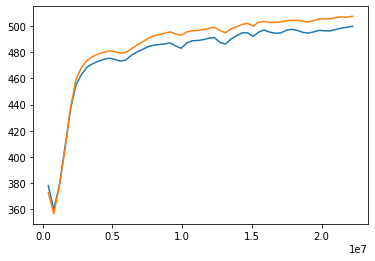

(Worker pid=35647) 3 21000 513.2234370327005
(Worker pid=35646) 23 21500 513.6574158513068
(Worker pid=35642) 16 22600 513.334722177703
(Worker pid=35643) 48 23300 513.6452081653403
(Worker pid=35645) 42 21200 513.557566686893
(Worker pid=35649) 39 20600 513.3777472423988
(Worker pid=35644) 30 21200 513.6883459749871
(Worker pid=35648) 33 21000 513.8727583374275
(Worker pid=35647) 11 21100 513.2859869698099
(Worker pid=35642) 51 22700 513.334722177703
(Worker pid=35646) 21 21600 513.6591586210777
Train:498.607
Test:506.514
(Worker pid=35643) 23 23400 513.7011387311987
(Worker pid=35645) 26 21300 513.557566686893
(Worker pid=35649) 41 20700 513.4968542686116
(Worker pid=35644) 33 21300 513.6883459749871
(Worker pid=35648) 68 21100 513.933626590944
(Worker pid=35647) 12 21200 513.3208726554559
(Worker pid=35646) 4 21700 513.7095603863097
(Worker pid=35643) 3 23500 513.7921405511003
(Worker pid=35642) 5 22800 513.3985364924794
(Worker pid=35645) 42 21400 513.6414837201461
(Worker pid=3564

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35648) 15 21300 514.031077629806
(Worker pid=35647) 39 21400 513.3329749834625
(Worker pid=35643) 68 23700 513.8135596412588
(Worker pid=35642) 43 23000 513.7959105683674
(Worker pid=35646) 36 21900 513.7265393930195
(Worker pid=35645) 42 21600 513.7194251454544
(Worker pid=35649) 3 21000 513.766158012975
(Worker pid=35644) 64 21600 513.764753813926
(Worker pid=35647) 1 21500 513.338907792726
(Worker pid=35643) 64 23800 513.9507085384942
Train:498.104
Test:506.479
(Worker pid=35648) 65 21400 514.031077629806
(Worker pid=35642) 28 23100 513.7962889913451
(Worker pid=35646) 66 22000 513.728595832959
(Worker pid=35645) 41 21700 513.7194251454544
(Worker pid=35644) 12 21700 513.8574107744626
(Worker pid=35649) 47 21100 513.766158012975
(Worker pid=35647) 65 21600 513.3401488374608
(Worker pid=35643) 28 23900 513.9507085384942
(Worker pid=35642) 56 23200 513.7962889913451
(Worker pid=35646) 63 22100 513.7325027023222
(Worker pid=35648) 59 21500 514.031077629806


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35644) 25 21800 513.8574107744626
(Worker pid=35645) 49 21800 514.1121962348253
(Worker pid=35649) 6 21200 513.7901447795555
(Worker pid=35643) 40 24000 513.9507085384942
(Worker pid=35647) 56 21700 513.3401488374608
(Worker pid=35642) 55 23300 513.7962889913451
(Worker pid=35646) 44 22200 513.7325027023222
(Worker pid=35648) 22 21600 514.0373546947445
(Worker pid=35644) 43 21900 513.8822033251292
(Worker pid=35645) 23 21900 514.1121962348253
(Worker pid=35643) 56 24100 513.9593964794984
(Worker pid=35649) 65 21300 513.7901447795555
(Worker pid=35642) 41 23400 513.8038149170965
(Worker pid=35647) 32 21800 513.4227020155244
(Worker pid=35646) 53 22300 513.7523576106273
(Worker pid=35648) 53 21700 514.0825001020481
(Worker pid=35644) 38 22000 513.8822033251292
(Worker pid=35643) 32 24200 513.9593964794984
(Worker pid=35645) 53 22000 514.1130966681388
Train:498.54
Test:506.351
(Worker pid=35642) 23 23500 513.84930159627
(Worker pid=35649) 24 21400 513.7901447795555
(Worker pid

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35648) 16 21900 514.0825001020481
(Worker pid=35643) 66 24400 513.9944905946217
(Worker pid=35644) 37 22200 513.8957143274487
(Worker pid=35642) 70 23700 513.9142273784445
(Worker pid=35645) 30 22200 514.1697757723107
(Worker pid=35646) 11 22600 514.0626709030403
(Worker pid=35649) 19 21600 513.9166132608722
(Worker pid=35647) 27 22100 513.6085799696276
(Worker pid=35648) 32 22000 514.1631220167957
(Worker pid=35643) 69 24500 514.1075024436409
(Worker pid=35644) 64 22300 513.9114328327215
(Worker pid=35645) 64 22300 514.1801590692648
(Worker pid=35642) 22 23800 513.9585394749251
(Worker pid=35649) 36 21700 513.9172234335462
(Worker pid=35646) 47 22700 514.0626709030403
(Worker pid=35647) 39 22200 513.711026473316
(Worker pid=35648) 69 22100 514.1893483654918
(Worker pid=35643) 21 24600 514.1075024436409
/home/mbyx3tk2/ray_results/ES_CropEnv_2022-03-14_12-29-19pwehz54t/checkpoint_000180/checkpoint-180


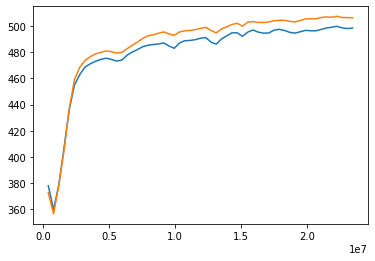

Train:497.612
Test:505.919
(Worker pid=35644) 37 22400 513.9114328327215
(Worker pid=35645) 50 22400 514.1854905814529
(Worker pid=35642) 26 23900 513.9585394749251
(Worker pid=35649) 48 21800 514.076076531971
(Worker pid=35646) 61 22800 514.0672363389463
(Worker pid=35647) 22 22300 513.8018486346882
(Worker pid=35648) 69 22200 514.2801379571962
(Worker pid=35643) 45 24700 514.119165332313
(Worker pid=35644) 10 22500 514.0373363154483
(Worker pid=35642) 46 24000 513.9635676762692
(Worker pid=35645) 67 22500 514.1854905814529


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35646) 11 22900 514.0944529042184
(Worker pid=35649) 10 21900 514.1679937508225
(Worker pid=35643) 42 24800 514.1552401747151
(Worker pid=35647) 60 22400 513.8018486346882
(Worker pid=35648) 50 22300 514.3186422814484
(Worker pid=35644) 65 22600 514.043016880655
(Worker pid=35642) 38 24100 514.0511163563757
(Worker pid=35645) 68 22600 514.1994359356443
(Worker pid=35646) 41 23000 514.148417686065
(Worker pid=35649) 58 22000 514.1968790506046
(Worker pid=35643) 52 24900 514.1718057901465
(Worker pid=35647) 11 22500 513.8096147615739
(Worker pid=35648) 31 22400 514.3397717817422
(Worker pid=35642) 4 24200 514.0511163563757
(Worker pid=35644) 41 22700 514.0681398177262
(Worker pid=35645) 42 22700 514.2269146512408
(Worker pid=35646) 67 23100 514.1553997029089
(Worker pid=35649) 56 22100 514.2039364949464
(Worker pid=35643) 44 25000 514.1718057901465
(Worker pid=35647) 62 22600 513.8753035831146
(Worker pid=35648) 67 22500 514.3397717817422


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:496.539
Test:504.927
(Worker pid=35642) 36 24300 514.0511163563757
(Worker pid=35644) 27 22800 514.0681398177262
(Worker pid=35645) 7 22800 514.230935673344
(Worker pid=35643) 40 25100 514.1850888198588
(Worker pid=35646) 56 23200 514.1553997029089
(Worker pid=35649) 57 22200 514.2287212218594
(Worker pid=35647) 70 22700 513.9284486655561
(Worker pid=35642) 70 24400 514.0714120068785
(Worker pid=35648) 21 22600 514.3406002967731
(Worker pid=35644) 29 22900 514.0862128593017
(Worker pid=35645) 58 22900 514.230935673344
(Worker pid=35643) 14 25200 514.2186796684159
(Worker pid=35646) 67 23300 514.1553997029089
(Worker pid=35649) 30 22300 514.2394369875349
(Worker pid=35647) 9 22800 514.0039458703974
(Worker pid=35642) 13 24500 514.0714120068785
(Worker pid=35648) 9 22700 514.3406002967731
(Worker pid=35643) 50 25300 514.2343636700131
(Worker pid=35644) 14 23000 514.0888006477793
(Worker pid=35645) 45 23000 514.2452047589478
(Worker pid=35646) 6 23400 514.2191673697729
(Worker pid=3

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35644) 14 23400 514.2856912019992
(Worker pid=35645) 28 23400 514.3361561119457
(Worker pid=35646) 69 23800 514.2680981353592
(Worker pid=35642) 24 25000 514.2762028513752
(Worker pid=35647) 42 23300 514.1999166066392
(Worker pid=35643) 1 25800 514.2863006553829
(Worker pid=35649) 69 22800 514.2979719495611
(Worker pid=35648) 54 23200 514.5585589415339
(Worker pid=35646) 5 23900 514.2703937969484
(Worker pid=35644) 62 23500 514.4348076795688
(Worker pid=35645) 64 23500 514.3863469020171
Train:493.79
Test:502.338
(Worker pid=35642) 70 25100 514.3714302621314
(Worker pid=35643) 12 25900 514.3298887953673
(Worker pid=35647) 61 23400 514.2585734991146
(Worker pid=35649) 27 22900 514.2979719495611
(Worker pid=35648) 70 23300 514.5585589415339
(Worker pid=35646) 60 24000 514.3807884706013
(Worker pid=35644) 46 23600 514.4438382295056
(Worker pid=35645) 19 23600 514.422330033923
(Worker pid=35642) 56 25200 514.4009926975957
/home/mbyx3tk2/ray_results/ES_CropEnv_2022-03-14_12-29-19

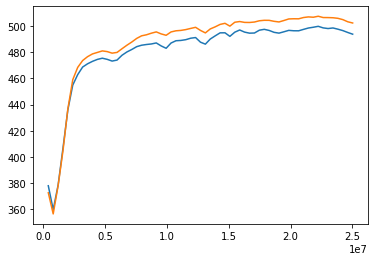

(Worker pid=35643) 9 26000 514.3756178083222
(Worker pid=35647) 69 23500 514.3342688729967
(Worker pid=35649) 41 23000 514.4047174049816
(Worker pid=35648) 28 23400 514.5638466512155
(Worker pid=35646) 68 24100 514.3807884706013
(Worker pid=35644) 47 23700 514.5022815108238
(Worker pid=35642) 70 25300 514.4834216696747
(Worker pid=35645) 2 23700 514.5024423579287
(Worker pid=35643) 32 26100 514.4451648404437
(Worker pid=35647) 27 23600 514.3459482525923
(Worker pid=35649) 8 23100 514.5850563846141
(Worker pid=35646) 7 24200 514.441841301108
(Worker pid=35648) 29 23500 514.5638466512155
(Worker pid=35644) 24 23800 514.5022815108238
(Worker pid=35642) 5 25400 514.5617534153656
(Worker pid=35645) 47 23800 514.5598704098882
(Worker pid=35643) 15 26200 514.5159414720371
(Worker pid=35647) 45 23700 514.4202928675376
(Worker pid=35649) 39 23200 514.6081958076091
(Worker pid=35646) 59 24300 514.5379456480757
(Worker pid=35648) 29 23600 514.583650541064


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train:496.013
Test:504.422
(Worker pid=35642) 29 25500 514.5617534153656
(Worker pid=35644) 36 23900 514.5022815108238
(Worker pid=35645) 16 23900 514.594870091723
(Worker pid=35643) 51 26300 514.6781158479565
(Worker pid=35649) 4 23300 514.653324226975
(Worker pid=35647) 1 23800 514.5388609246249
(Worker pid=35646) 10 24400 514.5991377266456
(Worker pid=35648) 50 23700 514.6111504494214
(Worker pid=35642) 42 25600 514.5718760056976
(Worker pid=35644) 47 24000 514.5102942574055
(Worker pid=35643) 5 26400 514.6781158479565
(Worker pid=35645) 16 24000 514.6370272646598
(Worker pid=35649) 14 23400 514.6584333836055
(Worker pid=35647) 13 23900 514.6117746831352
(Worker pid=35646) 17 24500 514.5991377266456
(Worker pid=35648) 40 23800 514.6663356136263
(Worker pid=35642) 66 25700 514.5718760056976
(Worker pid=35645) 59 24100 514.7495569988008
(Worker pid=35643) 32 26500 514.8590787442135
(Worker pid=35644) 27 24100 514.5167922762814
(Worker pid=35649) 14 23500 514.6630364075384
(Worker pid=

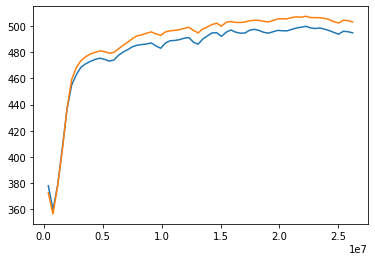

(Worker pid=35647) 6 24700 515.0401861045104
(Worker pid=35644) 67 24900 515.3685650813721
(Worker pid=35648) 63 24600 515.0919379732311
(Worker pid=35643) 21 27400 515.2621925801193
(Worker pid=35642) 36 26600 514.9363712677098
(Worker pid=35645) 49 24900 515.0408809413548
(Worker pid=35649) 55 24300 515.2243047652564
(Worker pid=35646) 13 25400 515.1105511758874
(Worker pid=35647) 6 24800 515.0531990758906
(Worker pid=35644) 13 25000 515.4427896443487
Train:494.45
Test:502.075
(Worker pid=35643) 20 27500 515.332474807812
(Worker pid=35648) 5 24700 515.202474989189
(Worker pid=35642) 43 26700 514.9702883640268
(Worker pid=35645) 7 25000 515.0408809413548
(Worker pid=35646) 7 25500 515.181297016811
(Worker pid=35647) 63 24900 515.1068896403514
(Worker pid=35649) 45 24400 515.2328117027331
(Worker pid=35644) 47 25100 515.4577300262143
(Worker pid=35643) 66 27600 515.3546575519739
(Worker pid=35642) 65 26800 515.0449671332168
(Worker pid=35648) 12 24800 515.202474989189
(Worker pid=35645

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35644) 21 25500 515.6251881441036
(Worker pid=35645) 40 25500 515.3608197259109
(Worker pid=35648) 36 25200 515.314923506699
(Worker pid=35643) 37 28100 515.5100008369476
(Worker pid=35646) 55 26000 515.3228257837679
(Worker pid=35642) 4 27300 515.2772079609942
(Worker pid=35649) 29 24900 515.62197222268
(Worker pid=35647) 21 25400 515.4158432721244
(Worker pid=35644) 29 25600 515.6251881441036
(Worker pid=35648) 54 25300 515.314923506699


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 60 25600 515.3608197259109
(Worker pid=35643) 61 28200 515.6199616290737
(Worker pid=35646) 55 26100 515.3601635243859
(Worker pid=35642) 70 27400 515.3045179761285
(Worker pid=35649) 4 25000 515.6683247801838
(Worker pid=35647) 8 25500 515.4258817561329
(Worker pid=35644) 45 25700 515.6419232576969
(Worker pid=35643) 26 28300 515.6199616290737
(Worker pid=35648) 50 25400 515.4294427792462
(Worker pid=35645) 69 25700 515.3952723970194
Train:485.696
Test:493.09
(Worker pid=35646) 17 26200 515.3882238239282
(Worker pid=35642) 4 27500 515.3107412144382
(Worker pid=35649) 23 25100 515.7588231881625
(Worker pid=35644) 24 25800 515.689660187056
(Worker pid=35643) 7 28400 515.6475584842678
(Worker pid=35647) 64 25600 515.4366571958186
(Worker pid=35645) 41 25800 515.3952723970194
(Worker pid=35648) 10 25500 515.4314388551802
(Worker pid=35646) 56 26300 515.4688110827644
(Worker pid=35642) 41 27600 515.3107412144382
(Worker pid=35649) 42 25200 515.8911700990362
(Worker pid=3

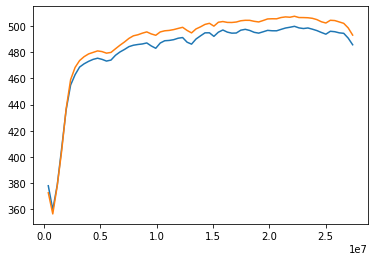

Train:486.283
Test:492.703
(Worker pid=35647) 31 25900 515.4433767152796
(Worker pid=35642) 69 27900 515.3388207788541
(Worker pid=35648) 22 25800 515.6432068011587
(Worker pid=35645) 8 26100 515.623231872873
(Worker pid=35646) 6 26600 515.5721835026073
(Worker pid=35643) 1 28800 515.6475584842678
(Worker pid=35649) 61 25500 515.9189613897141
(Worker pid=35644) 68 26200 515.7652194571629
(Worker pid=35642) 21 28000 515.3951206920625
(Worker pid=35645) 3 26200 515.6363217113159
(Worker pid=35647) 36 26000 515.4433767152796
(Worker pid=35648) 56 25900 515.6432068011587
(Worker pid=35646) 17 26700 515.5721835026073
(Worker pid=35643) 13 28900 515.6475584842678
(Worker pid=35644) 50 26300 515.7652194571629
(Worker pid=35649) 10 25600 515.9189613897141
(Worker pid=35642) 53 28100 515.3951206920625
(Worker pid=35647) 46 26100 515.4564148401714
(Worker pid=35645) 21 26300 515.6363217113159
(Worker pid=35648) 15 26000 515.6487632330604
(Worker pid=35646) 37 26800 515.5936636914128
(Worker pid=

/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35643) 23 29700 515.7231921446574
(Worker pid=35645) 3 27000 515.6469418498372
(Worker pid=35649) 44 26300 515.9446625418632
(Worker pid=35648) 16 26700 515.7615474922366
(Worker pid=35647) 55 26800 515.4872621446561
(Worker pid=35646) 70 27500 515.6308549886246
(Worker pid=35642) 11 28900 515.4830161039046
(Worker pid=35643) 1 29800 515.7353601921462
(Worker pid=35644) 29 27100 515.8441809313149
(Worker pid=35645) 11 27100 515.6716081485996
(Worker pid=35648) 44 26800 515.7615474922366
(Worker pid=35649) 31 26400 515.9487605883189
(Worker pid=35647) 10 26900 515.5024336736145
(Worker pid=35646) 9 27600 515.6308549886246
(Worker pid=35643) 32 29900 515.7353601921462
(Worker pid=35642) 59 29000 515.4830161039046
(Worker pid=35644) 18 27200 515.8441809313149
(Worker pid=35645) 14 27200 515.6716081485996
(Worker pid=35649) 20 26500 515.9487605883189
(Worker pid=35647) 49 27000 515.5024336736145
(Worker pid=35648) 7 26900 515.7615474922366
Train:492.374
Test:498.31
(Worker pid=

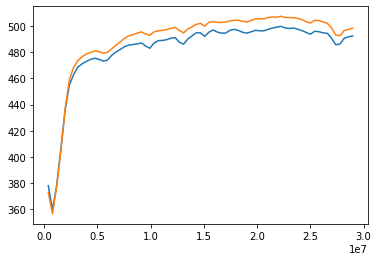

(Worker pid=35642) 25 29200 515.4943749155603
(Worker pid=35646) 25 27800 515.635913794919
(Worker pid=35644) 70 27400 515.8472928884339
(Worker pid=35645) 22 27400 515.6716081485996
(Worker pid=35648) 36 27100 515.7869979918069
(Worker pid=35649) 63 26700 515.9680145357887
(Worker pid=35647) 37 27200 515.5303234057253
(Worker pid=35643) 1 30200 515.7353601921462
(Worker pid=35642) 22 29300 515.4943749155603
(Worker pid=35646) 60 27900 515.635913794919


/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/agents/es/es.py:343: RuntimeWarning: Mean of empty slice.
  episode_len_mean=eval_lengths.mean(),
/home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Worker pid=35645) 26 27500 515.6716081485996
(Worker pid=35644) 49 27500 515.8472928884339
(Worker pid=35648) 2 27200 515.7869979918069
(Worker pid=35647) 59 27300 515.5303234057253
(Worker pid=35649) 23 26800 515.9680145357887
(Worker pid=35643) 21 30300 515.7353601921462
(Worker pid=35642) 48 29400 515.4943749155603
(Worker pid=35646) 49 28000 515.635913794919
(Worker pid=35645) 15 27600 515.6716081485996
(Worker pid=35644) 20 27600 515.8472928884339
(Worker pid=35648) 33 27300 515.8097860507763
Train:493.067
Test:499.082
(Worker pid=35647) 41 27400 515.5303234057253
(Worker pid=35649) 29 26900 515.9680145357887
(Worker pid=35643) 3 30400 515.7353601921462
(Worker pid=35642) 46 29500 515.5376777140913
(Worker pid=35646) 18 28100 515.635913794919
(Worker pid=35645) 41 27700 515.6716081485996
(Worker pid=35644) 60 27700 515.8472928884339
(Worker pid=35647) 36 27500 515.5303234057253
(Worker pid=35643) 2 30500 515.7523024547311
(Worker pid=35648) 32 27400 515.8097860507763
(Worker pid=

KeyboardInterrupt: 

In [16]:
proftrain=[]
proftest=[]
timesteps=[]

for i in range(1,500001):
    result = agent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = agent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('ppo70_day7_smt4_dayshift_noforecast_neweto_endreward.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config=copy.deepcopy(envconfig)
        test_env_config['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')


In [ ]:
# from ray.rllib.agents.impala import ImpalaTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.dqn.apex import ApexTrainer, APEX_DEFAULT_CONFIG


In [ ]:
# config=DEFAULT_CONFIG.copy()
# config['gamma'] = 0.99999
# config['framework'] = 'torch'
# config['num_workers'] = 8
# config['num_gpus'] = 0
# config['model']['fcnet_hiddens'] = [128]*4
# config['rollout_fragment_length'] = 160
# config['train_batch_size'] = 4000
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed



In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 16
# config['num_gpus'] = 1
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# # config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# # config['train_batch_size'] = 1028
# # config['timesteps_per_iteration'] = 4000
# # config['Q_model']['fcnet_hiddens'] = [128]*4
# # config['policy_model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# # config['initial_alpha'] = 0.2
# config['optimization']['actor_learning_rate'] = 1e-2
# config['optimization']['critic_learning_rate'] = 1e-2
# config['optimization']['entropy_learning_rate'] = 1e-2

# # config['model']['use_lstm'] = True
# # config['model']['lstm_cell_size'] = 64
# # config['model']['max_seq_len'] = 40

In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 8
# config['num_gpus'] = 0
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# # config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# config['train_batch_size'] = 4000
# config['model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# config['env_config']={"evaluation_run":False}
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 8
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# config['train_batch_size'] = 1028
# config['Q_model']['fcnet_hiddens'] = [128]*4
# config['policy_model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# config['target_network_update_freq'] = 1

# # config['model']['use_lstm'] = True
# # config['model']['lstm_cell_size'] = 64
# # config['model']['max_seq_len'] = 17

In [ ]:
# agent = PPOTrainer(config, CropEnv)
# agent = SACTrainer(config, CropEnv)
# agent = ImpalaTrainer(config, CropEnv)
# agent = ApexTrainer(config, CropEnv)


# checkpoint_path
# agent.restore(checkpoint_path)